You can find the dataset using the extracted features [here](https://www.kaggle.com/fleanend/birds-songs-numeric-dataset).

In [1]:
import numpy as np
import matplotlib.pyplot as plt #ploting graphs
import pandas as pd # Accessing csv files 
import pickle #Storing model
from librosa import core, onset, feature, display #Extracting features from audio files
import soundfile as sf #Reading audio files
import umap #demension reduction tecnique
from IPython.display import Audio
import sklearn #SVM model
import sys #access system specific param and func

In [2]:
df = pd.read_csv("./birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [3]:
print(len(set(df['genus'])))
print(len(set(df['species'])))

66
85


In [9]:
def load_audio(file_id):
    data, samplerate = sf.read("./songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(y=data, sr=samplerate, hop_length=512)
    #https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [12]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    try:
        sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    except:
        print(file_id)
        continue
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

101371
98400
27060


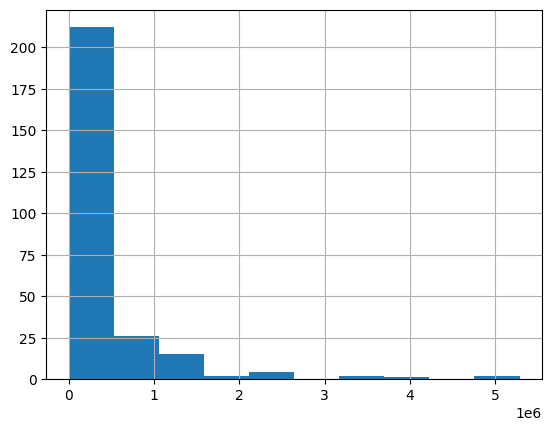

count    2.640000e+02
mean     4.286174e+05
std      6.621262e+05
min      0.000000e+00
25%      9.920000e+04
50%      2.344960e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [13]:
df['length'].hist()
plt.show()
df['length'].describe()

In [14]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/,847360.0,137
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,251392.0,40
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,0.0,0
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,325632.0,53


In [15]:
# To relax the problem we'll consider the genus as the label instead of the species
# We use 23 windows per genus to have a balanced data set

n_windows = df.groupby('species')['windows'].sum().min()
n_windows

np.int64(20)

In [17]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    if file_id in [101371, 98400, 27060]:
        continue
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        

In [18]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [20]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(y=windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(y=windows_fixed[species][i], sr=sample_rate)
       # https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        data_point = pd.DataFrame([data_point])
        new_dataset = pd.concat([new_dataset, data_point],ignore_index=True)

new_dataset.head()

c:\Users\K Samarth N Kamath\Bird-Vocalization-Detection-System\.venv\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


,species,genus,spec_centr_0,chromogram_0_0,chromogram_1_0,chromogram_2_0,chromogram_3_0,chromogram_4_0,chromogram_5_0,chromogram_6_0,...,chromogram_2_12,chromogram_3_12,chromogram_4_12,chromogram_5_12,chromogram_6_12,chromogram_7_12,chromogram_8_12,chromogram_9_12,chromogram_10_12,chromogram_11_12
0,flammea,Acanthis,2442.089677,0.645542,0.349450,0.166184,0.096049,0.093169,0.073407,0.034041,...,0.412498,0.243003,0.112923,0.046037,0.028564,0.061722,0.129256,0.452654,1.000000,0.714536
1,flammea,Acanthis,2440.628987,1.000000,0.620424,0.318773,0.151869,0.094209,0.094567,0.068958,...,0.554592,0.391417,0.218344,0.100698,0.040755,0.028357,0.067543,0.145454,0.510272,1.000000
2,flammea,Acanthis,2440.042293,1.000000,0.622055,0.320582,0.152584,0.094716,0.095581,0.070223,...,0.553241,0.390372,0.218837,0.101043,0.040824,0.027893,0.066034,0.143134,0.505659,1.000000
3,flammea,Acanthis,2439.988776,1.000000,0.621762,0.320039,0.152444,0.095059,0.096328,0.070788,...,0.551704,0.388921,0.217786,0.100475,0.040764,0.027681,0.065430,0.142715,0.506232,1.000000
4,flammea,Acanthis,2442.195673,1.000000,0.621490,0.319785,0.152318,0.095352,0.097074,0.071412,...,0.549899,0.387363,0.217078,0.100067,0.040400,0.027469,0.064765,0.142472,0.506689,1.000000


In [21]:
for i in new_dataset.columns:
    print(i)

species
genus
spec_centr_0
chromogram_0_0
chromogram_1_0
chromogram_2_0
chromogram_3_0
chromogram_4_0
chromogram_5_0
chromogram_6_0
chromogram_7_0
chromogram_8_0
chromogram_9_0
chromogram_10_0
chromogram_11_0
spec_centr_1
chromogram_0_1
chromogram_1_1
chromogram_2_1
chromogram_3_1
chromogram_4_1
chromogram_5_1
chromogram_6_1
chromogram_7_1
chromogram_8_1
chromogram_9_1
chromogram_10_1
chromogram_11_1
spec_centr_2
chromogram_0_2
chromogram_1_2
chromogram_2_2
chromogram_3_2
chromogram_4_2
chromogram_5_2
chromogram_6_2
chromogram_7_2
chromogram_8_2
chromogram_9_2
chromogram_10_2
chromogram_11_2
spec_centr_3
chromogram_0_3
chromogram_1_3
chromogram_2_3
chromogram_3_3
chromogram_4_3
chromogram_5_3
chromogram_6_3
chromogram_7_3
chromogram_8_3
chromogram_9_3
chromogram_10_3
chromogram_11_3
spec_centr_4
chromogram_0_4
chromogram_1_4
chromogram_2_4
chromogram_3_4
chromogram_4_4
chromogram_5_4
chromogram_6_4
chromogram_7_4
chromogram_8_4
chromogram_9_4
chromogram_10_4
chromogram_11_4
spec_centr_

In [22]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(y=windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(y=windows_fixed_test[species][i], sr=sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        data_point = pd.DataFrame([data_point])
        new_dataset_test = pd.concat([new_dataset_test,data_point],ignore_index=True)

new_dataset_test.head()

c:\Users\K Samarth N Kamath\Bird-Vocalization-Detection-System\.venv\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


,species,genus,spec_centr_0,chromogram_0_0,chromogram_1_0,chromogram_2_0,chromogram_3_0,chromogram_4_0,chromogram_5_0,chromogram_6_0,...,chromogram_2_12,chromogram_3_12,chromogram_4_12,chromogram_5_12,chromogram_6_12,chromogram_7_12,chromogram_8_12,chromogram_9_12,chromogram_10_12,chromogram_11_12
0,flammea,Acanthis,2439.945547,0.645315,0.349250,0.166102,0.096156,0.093512,0.073729,0.034165,...,0.411641,0.242523,0.112759,0.045962,0.028441,0.061449,0.128977,0.452955,1.000000,0.714293
1,flammea,Acanthis,2443.446204,1.000000,0.620579,0.318997,0.151927,0.094071,0.094180,0.068650,...,0.555383,0.392124,0.218584,0.100603,0.040804,0.028532,0.067722,0.145757,0.509797,1.000000
2,flammea,Acanthis,2441.397755,1.000000,0.620250,0.318581,0.151816,0.094349,0.094949,0.069267,...,0.553780,0.390659,0.218012,0.100694,0.040641,0.028188,0.067299,0.145260,0.510484,1.000000
3,flammea,Acanthis,2443.366373,1.000000,0.620077,0.318395,0.151747,0.094501,0.095324,0.069563,...,0.552913,0.389868,0.217546,0.100458,0.040529,0.028066,0.066965,0.145106,0.510679,1.000000
4,flammea,Acanthis,2444.563339,1.000000,0.621917,0.320325,0.152506,0.094887,0.095952,0.070502,...,0.552449,0.389643,0.218332,0.100761,0.040778,0.027789,0.065724,0.142933,0.505951,1.000000


In [23]:
# Prepare dataset to fit a simple model

features= list(new_dataset.columns)
features.remove('species')
features.remove('genus')

X = new_dataset[features].values
y = new_dataset['species'].values

X_test = new_dataset_test[features].values
y_test = new_dataset_test['species'].values

In [24]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X, y)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [25]:
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.960691823899371

In [26]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X,y)
y_pred_nb = clf_nb.predict(X_test)

In [27]:
sklearn.metrics.accuracy_score(y_pred=y_pred_nb, y_true=y_test)

0.8851596516690856

In [28]:
# The data can be used to predict, let's export the newly created datasets

new_dataset.to_csv("train.csv")
new_dataset_test.to_csv("test.csv")

In [29]:
filename = 'svm.sav'
pickle.dump(clf, open(filename, 'wb'))

In [30]:
filename = 'naive.sav'
pickle.dump(clf_nb, open(filename, 'wb'))